In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# 取 X值 (20183-20211)

In [58]:
company_factor = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

#稅後淨利率 #營業毛利率 #流動比率 #速動比率 #負債比率 #應收帳款週轉率  #現金再投資比率 #董監事持股比利 
#董監事質押比利 #外資持股比例 # >1000張大股東持股比率 # <400張股東持股比率
#平均持股張數

company_factor

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,2302,20183,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,2302,20184,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,2302,20191,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,2302,20192,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,2302,20193,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,8299,20201,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,8299,20202,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,8299,20203,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,8299,20204,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


# 取 Y值 (20184-20212)

In [59]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')
Roe_rul

,roe_rate
0,0.42
1,-0.20
2,0.85
3,0.17
4,-0.80
...,...
1634,4.01
1635,6.07
1636,11.76
1637,4.71


<h1>資料前處理

In [60]:
#缺值檢視
company_factor.isnull().sum()

stock_code                                 0
stock_report_date                          0
operating_gross_rate                       0
net_profit_rate                            0
revenue_growth_rate                        0
                                          ..
export_usd_value_381800                    0
new_cases_smoothed_USA                     0
new_cases_smoothed_OWID_EUR                0
new_cases_smoothed_TWN                     0
people_fully_vaccinated_per_hundred_USA    0
Length: 63, dtype: int64

In [61]:
Roe_rul.isnull().sum()

roe_rate    0
dtype: int64

In [62]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [63]:
#定義股東權益報酬率 >平均者為表現良好
m2 = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [64]:
X = company_factor[['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'roe_rate',
       'roa_rate', 'foreign_rate_bys', 'avg_import_rate', 'avg_export_rate',
       'export_kgm_weight_37050000306', 'new_cases_smoothed_USA',
       'new_cases_smoothed_TWN']]

# X =  company_factor[['net_profit_rate','operating_gross_rate', 'roe_rate','roa_rate',
#                     'current_rate', 'quick_rate',  'debt_rate',  'receivables_turnover_rate', 
#                     'cash_reinvest_rate','export_usd_value_381800','new_cases_smoothed_TWN',
#                      'import_usd_value_37079090','avg_import_rate']]

y = Roe_rul['roe_rate']
Y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
# print('y:',y.value_counts(normalize = True))

x.shape:  (1639, 14)
y.shape:  (1639,)


<h3> ROE:  755 筆標記為 0 ； 884 筆為 1
<h3> 基準準確度(空準確度) 為 53.93%

## 假設檢定

<h4>H0 (虛無假設): 特徵與應變量 (y) 沒有關係
<h4>針對每個特徵進行檢定，判定是否有顯著關係

<h3> 建立 篩選器 與 篩選方式
<h3> 篩選方式可用 f_classif, chi2

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

In [37]:
k_best = SelectKBest(f_classif, k =14)
k_best.fit_transform(X,y)

array([[ 3.8030000e+01,  1.3350000e+01,  1.7770000e+01, ...,
         6.1860000e+03,  0.0000000e+00,  0.0000000e+00],
       [ 4.0930000e+01,  5.2200000e+00, -9.1000000e-01, ...,
         6.3880000e+03,  0.0000000e+00,  0.0000000e+00],
       [ 3.7030000e+01, -3.0000000e+00, -6.3300000e+00, ...,
         7.6650000e+03,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.2610000e+01,  1.5410000e+01, -3.7100000e+00, ...,
         8.9640000e+03,  5.0018100e+04,  4.0700000e+00],
       [ 2.3050000e+01,  2.9470000e+01, -2.5200000e+00, ...,
         9.4070000e+03,  1.3475331e+05,  7.0400000e+00],
       [ 2.9710000e+01,  1.3090000e+01,  1.7000000e-01, ...,
         1.3503000e+04,  1.2017833e+05,  6.4900000e+00]])

<h3> 通常 P-value < 0.05 即可證明兩者有關聯，而拒絕 H0

In [38]:
p_values = pd.DataFrame({"Column":X.columns,"P-value":k_best.pvalues_}).sort_values("P-value")
p_values[p_values["P-value"]<0.01]

,Column,P-value
6,roe_rate,2.224315e-146
1,net_profit_rate,4.662510e-115
7,roa_rate,3.730743e-103
0,operating_gross_rate,4.102008e-59
4,quick_rate,1.404020e-24
3,current_rate,1.294557e-22
5,cash_reinvest_rate,2.186756e-22
2,revenue_growth_rate,8.846199e-09
11,export_kgm_weight_37050000306,2.377809e-06
12,new_cases_smoothed_USA,1.002982e-03


In [39]:
high_corr = p_values[p_values["P-value"]<0.01].iloc[:,0]
high_corr

6                          roe_rate
1                   net_profit_rate
7                          roa_rate
0              operating_gross_rate
4                        quick_rate
3                      current_rate
5                cash_reinvest_rate
2               revenue_growth_rate
11    export_kgm_weight_37050000306
12           new_cases_smoothed_USA
10                  avg_export_rate
9                   avg_import_rate
Name: Column, dtype: object

<h3>篩選出有顯著關係的特徵加入為 X

In [40]:
X_sel = X[high_corr]
X_sel

,roe_rate,net_profit_rate,roa_rate,operating_gross_rate,quick_rate,current_rate,cash_reinvest_rate,revenue_growth_rate,export_kgm_weight_37050000306,new_cases_smoothed_USA,avg_export_rate,avg_import_rate
0,1.07,13.35,0.91,38.03,103.70,154.53,1.74,17.77,6186,0.00,30.619,30.719
1,0.42,5.22,0.37,40.93,110.41,166.92,1.34,-0.91,6388,0.00,30.801,30.901
2,-0.20,-3.00,-0.14,37.03,109.89,171.94,1.51,-6.33,7665,0.00,30.780,30.880
3,0.85,10.26,0.74,32.10,114.79,174.72,2.17,-2.46,7615,0.00,31.087,31.187
4,0.17,2.29,0.17,28.78,116.92,170.04,4.32,-6.54,6374,0.00,31.148,31.248
...,...,...,...,...,...,...,...,...,...,...,...,...
1634,6.29,14.75,4.71,30.43,199.20,326.95,-0.03,37.71,7182,1818.75,30.063,30.163
1635,4.01,10.91,2.97,24.76,181.73,299.48,6.49,10.95,7633,26218.70,29.841,29.941
1636,6.07,15.41,4.61,22.61,240.63,363.99,5.25,-3.71,8964,50018.10,29.399,29.499
1637,11.76,29.47,8.79,23.05,230.20,317.33,11.28,-2.52,9407,134753.31,28.683,28.783


In [41]:
# 輸入數據調成標準值以免各特徵影響不同
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

In [42]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 12


# 1. 以財務數據預測 ROE

<h3>LogisticRegression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
lr_params = [0.001,0.01, 0.1, 1, 10, 100,1000]
result = []
for c in lr_params:
    tmp = [c]
    log = LogisticRegression(C=c)
    log.fit(X_train, y_train)
    tmp.append(float(log.score(X_train, y_train)))
    log_pred = log.predict(X_test)
    tmp.append(float(accuracy_score(y_test, log_pred)))
    tmp.append(float(f1_score(y_test, log_pred)))
    result.append(tmp)
    
df =pd.DataFrame(result,columns = ["C","Train_accuracy","Test_accuracy","Test_F1"])
df

,C,Train_accuracy,Test_accuracy,Test_F1
0,0.001,0.783371,0.753049,0.800983
1,0.010,0.802441,0.798780,0.821622
2,0.100,0.804729,0.789634,0.810959
3,1.000,0.807780,0.783537,0.804408
4,10.000,0.808543,0.780488,0.802198
5,100.000,0.809306,0.777439,0.800000
6,1000.000,0.808543,0.777439,0.800000


In [53]:
lr_param = {"C":[0.001,0.01, 0.1, 1, 10, 100,1000]}
grid = GridSearchCV(LogisticRegression(),lr_param)
grid.fit(X_train,y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.cv_results_['mean_score_time'].mean())

0.8039706266507997
{'C': 10}
0.0003628526415143694


In [54]:
df[df['Test_accuracy'] == df['Test_accuracy'].max()]

,C,Train_accuracy,Test_accuracy,Test_F1
1,0.01,0.802441,0.79878,0.821622


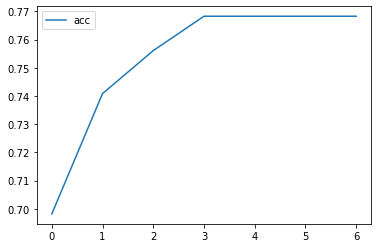

In [25]:
plt.plot(df['Test_accuracy'], label='acc')
# plt.plot(df['Test_F1'], label='F1')
plt.legend()

<h3>RandomForestClassifier

In [50]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

n_estimators = [10,50,100,200,500]
max_depth = [None, 1, 3, 5, 7, 10]

#Create a Gaussian Classifier
results1 = []
for n_estimator in n_estimators:
    for depth in max_depth:
        tmp = [n_estimator, depth]
        
        forest=RandomForestClassifier(n_estimators=n_estimator,max_depth = depth)

        #Train the model using the training sets y_pred=clf.predict(X_test)
        forest.fit(X_train, y_train)

        forest_pred=forest.predict(X_test)
        
        tmp.append(float(accuracy_score(y_test, forest_pred)))
        tmp.append(float(f1_score(y_test, forest_pred)))
        
        results1.append(tmp)
        
df_tree =pd.DataFrame(results1,columns = ["n_estimators","max_depth","Test_accuracy","Test_F1"])
df_tree

,n_estimators,max_depth,Test_accuracy,Test_F1
0,10,NaN,0.804878,0.818182
1,10,1.0,0.795732,0.821333
2,10,3.0,0.807927,0.832891
3,10,5.0,0.795732,0.819407
4,10,7.0,0.789634,0.816000
5,10,10.0,0.817073,0.833333
6,50,NaN,0.798780,0.816667
7,50,1.0,0.783537,0.812665
8,50,3.0,0.798780,0.820652
9,50,5.0,0.804878,0.824176


In [55]:
forest_param = {"n_estimators":[10,50,100,200,500],'max_depth':[None, 1, 3, 5, 7, 10]}

grid = GridSearchCV(RandomForestClassifier(),forest_param)
grid.fit(X_train,y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.cv_results_['mean_score_time'].mean())

0.8245871186834238
{'max_depth': 10, 'n_estimators': 200}
0.016965467135111493


In [27]:
df_tree[df_tree['Test_accuracy'] == df_tree['Test_accuracy'].max()]

,n_estimators,max_depth,Test_accuracy,Test_F1
11,50,10.0,0.814024,0.836461


In [28]:
# pred_test = np.round(forest_pred).flatten()
# cm = confusion_matrix(y_test, pred_test)
# cm

<H1>2. 加入環境因素 特徵篩選

In [29]:
#取得需要的特徵
addenv_factor2 = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

addenv_factor2 = addenv_factor2.drop(['stock_code','stock_report_date'],axis=1)
addenv_factor2

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,1.07,0.91,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,0.42,0.37,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,0.85,0.74,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,0.17,0.17,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,6.29,4.71,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,4.01,2.97,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,6.07,4.61,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,11.76,8.79,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


In [30]:
X2 = addenv_factor2

y1 = Roe_rul['roe_rate']

Y1 = Roe_rul['roe_rate1']

print("X2.shape: " ,X2.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X2.shape:  (1639, 61)
y1.shape:  (1639,)
y1.sum(): 3870.04


<h3>建立篩選器與篩選方式

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

In [32]:
k_best2 = SelectKBest(f_classif, k =5)
k_best2.fit_transform(X2,y1)

array([[ 3.8030e+01,  1.3350e+01,  1.0370e+02,  1.0700e+00,  9.1000e-01],
       [ 4.0930e+01,  5.2200e+00,  1.1041e+02,  4.2000e-01,  3.7000e-01],
       [ 3.7030e+01, -3.0000e+00,  1.0989e+02, -2.0000e-01, -1.4000e-01],
       ...,
       [ 2.2610e+01,  1.5410e+01,  2.4063e+02,  6.0700e+00,  4.6100e+00],
       [ 2.3050e+01,  2.9470e+01,  2.3020e+02,  1.1760e+01,  8.7900e+00],
       [ 2.9710e+01,  1.3090e+01,  1.9193e+02,  4.7100e+00,  3.4100e+00]])

In [33]:
p_values2 = pd.DataFrame({"Column":X2.columns,"P-value":k_best2.pvalues_}).sort_values("P-value")
p_values2[p_values2["P-value"]<0.01]

,Column,P-value
8,roe_rate,2.224315e-146
1,net_profit_rate,4.662510e-115
9,roa_rate,3.730743e-103
0,operating_gross_rate,4.102008e-59
4,quick_rate,1.404020e-24
3,current_rate,1.294557e-22
7,cash_reinvest_rate,2.186756e-22
6,receivables_turnover_rate,5.597404e-17
14,change_rate_bys,5.008608e-11
2,revenue_growth_rate,8.846199e-09


In [34]:
high_corr2 = p_values2[p_values2["P-value"]<0.01].iloc[:,0]
high_corr2

8                                    roe_rate
1                             net_profit_rate
9                                    roa_rate
0                        operating_gross_rate
4                                  quick_rate
3                                current_rate
7                          cash_reinvest_rate
6                   receivables_turnover_rate
14                            change_rate_bys
2                         revenue_growth_rate
60    people_fully_vaccinated_per_hundred_USA
45              export_kgm_weight_37050000306
54                    export_usd_value_848620
58                new_cases_smoothed_OWID_EUR
57                     new_cases_smoothed_USA
5                                   debt_rate
24                            avg_export_rate
23                            avg_import_rate
Name: Column, dtype: object

In [35]:
X2_sel = X2[high_corr2]
X2_sel

,roe_rate,net_profit_rate,roa_rate,operating_gross_rate,quick_rate,current_rate,cash_reinvest_rate,receivables_turnover_rate,change_rate_bys,revenue_growth_rate,people_fully_vaccinated_per_hundred_USA,export_kgm_weight_37050000306,export_usd_value_848620,new_cases_smoothed_OWID_EUR,new_cases_smoothed_USA,debt_rate,avg_export_rate,avg_import_rate
0,1.07,13.35,0.91,38.03,103.70,154.53,1.74,3.31,-4.80,17.77,0.00,6186,61504,0.00,0.00,18.22,30.619,30.719
1,0.42,5.22,0.37,40.93,110.41,166.92,1.34,4.35,-4.80,-0.91,0.00,6388,93168,0.00,0.00,16.86,30.801,30.901
2,-0.20,-3.00,-0.14,37.03,109.89,171.94,1.51,0.99,10.33,-6.33,0.00,7665,72410,0.00,0.00,16.38,30.780,30.880
3,0.85,10.26,0.74,32.10,114.79,174.72,2.17,2.00,-7.00,-2.46,0.00,7615,77517,0.00,0.00,16.63,31.087,31.187
4,0.17,2.29,0.17,28.78,116.92,170.04,4.32,3.10,-0.03,-6.54,0.00,6374,118643,0.00,0.00,17.45,31.148,31.248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,6.29,14.75,4.71,30.43,199.20,326.95,-0.03,1.99,-9.13,37.71,0.00,7182,71220,5251.16,1818.75,25.75,30.063,30.163
1635,4.01,10.91,2.97,24.76,181.73,299.48,6.49,4.28,6.13,10.95,0.00,7633,83758,22066.62,26218.70,27.74,29.841,29.941
1636,6.07,15.41,4.61,22.61,240.63,363.99,5.25,6.20,-3.40,-3.71,0.00,8964,88039,27565.47,50018.10,23.66,29.399,29.499
1637,11.76,29.47,8.79,23.05,230.20,317.33,11.28,8.12,7.97,-2.52,0.29,9407,125111,197678.98,134753.31,26.09,28.683,28.783


In [36]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [37]:
X2_scaled = pd.DataFrame()
a, b = X2_sel.shape

for i in range(b):
    x2_new = mean_norm(X2_sel[X2_sel.columns[i]])
    X2_scaled.insert(i,X2_sel.columns[i],x2_new)
X2_scaled

,roe_rate,net_profit_rate,roa_rate,operating_gross_rate,quick_rate,current_rate,cash_reinvest_rate,receivables_turnover_rate,change_rate_bys,revenue_growth_rate,people_fully_vaccinated_per_hundred_USA,export_kgm_weight_37050000306,export_usd_value_848620,new_cases_smoothed_OWID_EUR,new_cases_smoothed_USA,debt_rate,avg_export_rate,avg_import_rate
0,-0.182515,0.214147,-0.220846,0.310530,-0.513366,-0.553189,-0.205327,-0.161824,-0.704595,0.195944,-0.322412,-0.899728,-1.108827,-0.552314,-0.625915,-0.818028,0.561617,0.561617
1,-0.290044,0.060193,-0.381183,0.420361,-0.494960,-0.520781,-0.239816,-0.064074,-0.704595,-0.294623,-0.322412,-0.798707,-0.080664,-0.552314,-0.625915,-0.898471,0.761148,0.761148
2,-0.392611,-0.095466,-0.532612,0.272657,-0.496387,-0.507650,-0.225158,-0.379883,0.680181,-0.436961,-0.322412,-0.160078,-0.754698,-0.552314,-0.625915,-0.926863,0.738125,0.738125
3,-0.218909,0.155633,-0.271322,0.085944,-0.482945,-0.500379,-0.168251,-0.284953,-0.905951,-0.335329,-0.322412,-0.185083,-0.588868,-0.552314,-0.625915,-0.912075,1.074696,1.074696
4,-0.331402,0.004708,-0.440567,-0.039793,-0.477102,-0.512620,0.017126,-0.181562,-0.268020,-0.442476,-0.322412,-0.805709,0.746536,-0.552314,-0.625915,-0.863573,1.141572,1.141572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.681029,0.240658,0.907451,0.022697,-0.251399,-0.102197,-0.357940,-0.285892,-1.100900,0.719600,-0.322412,-0.401627,-0.793339,-0.478457,-0.588310,-0.372635,-0.047939,-0.047939
1635,0.303849,0.167942,0.390810,-0.192042,-0.299321,-0.174049,0.204228,-0.070653,0.295775,0.016839,-0.322412,-0.176081,-0.386217,-0.241950,-0.083800,-0.254929,-0.291323,-0.291323
1636,0.644634,0.253157,0.877759,-0.273468,-0.137752,-0.005312,0.097313,0.109809,-0.576460,-0.368156,-0.322412,0.489554,-0.247208,-0.164609,0.408293,-0.496257,-0.775898,-0.775898
1637,1.585929,0.519405,2.118886,-0.256804,-0.166362,-0.127359,0.617232,0.290272,0.464181,-0.336905,-0.259081,0.711099,0.956559,2.228015,2.160336,-0.352525,-1.560866,-1.560866


In [38]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X2_train, X2_test, y1_train, y1_test = train_test_split(X2_scaled, Y1, test_size=0.2,random_state=1)
N, D = X2_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 18


<h3>LogisticRegression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
lr_params = [0.001,0.01, 0.1, 1, 10, 100,1000]
result3 = []
for c in lr_params:
    tmp = [c]
    log = LogisticRegression(C=c)
    log.fit(X2_train, y1_train)
    tmp.append(float(log.score(X2_train, y1_train)))
    log_pred = log.predict(X2_test)
    tmp.append(float(accuracy_score(y_test, log_pred)))
    tmp.append(float(f1_score(y_test, log_pred)))
    result3.append(tmp)
    
df_lr =pd.DataFrame(result3,columns = ["C","Train_accuracy","Test_accuracy","Test_F1"])
df_lr

,C,Train_accuracy,Test_accuracy,Test_F1
0,0.001,0.788711,0.753049,0.792839
1,0.010,0.809306,0.783537,0.808625
2,0.100,0.816934,0.774390,0.798913
3,1.000,0.824561,0.771341,0.796748
4,10.000,0.825324,0.783537,0.808625
5,100.000,0.825324,0.783537,0.808625
6,1000.000,0.825324,0.783537,0.808625


In [45]:
df_lr[df_lr['Test_accuracy'] == df_lr['Test_accuracy'].max()]

,C,Train_accuracy,Test_accuracy,Test_F1
1,0.01,0.809306,0.783537,0.808625
4,10.00,0.825324,0.783537,0.808625
5,100.00,0.825324,0.783537,0.808625
6,1000.00,0.825324,0.783537,0.808625


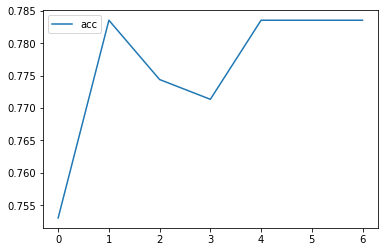

In [46]:
plt.plot(df_lr['Test_accuracy'], label='acc')
# plt.plot(df['Test_F1'], label='F1')
plt.legend()

<h3>RandomForestClassifier

In [42]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

n_estimators = [10,50,100,200,500]
max_depth = [None, 1, 3, 5, 7, 10]

#Create a Gaussian Classifier
results4 = []
for n_estimator in n_estimators:
    for depth in max_depth:
        tmp = [n_estimator, depth]
        
        forest=RandomForestClassifier(n_estimators=n_estimator,max_depth = depth)

        #Train the model using the training sets y_pred=clf.predict(X_test)
        forest.fit(X2_train, y1_train)

        forest_pred=forest.predict(X2_test)
        
        tmp.append(float(accuracy_score(y1_test, forest_pred)))
        tmp.append(float(f1_score(y1_test, forest_pred)))
        
        results4.append(tmp)
        
df_tree1 =pd.DataFrame(results4,columns = ["n_estimators","max_depth","Test_accuracy","Test_F1"])
df_tree1

,n_estimators,max_depth,Test_accuracy,Test_F1
0,10,NaN,0.823171,0.837989
1,10,1.0,0.780488,0.810526
2,10,3.0,0.801829,0.824798
3,10,5.0,0.814024,0.836461
4,10,7.0,0.798780,0.820652
5,10,10.0,0.814024,0.835580
6,50,NaN,0.807927,0.827397
7,50,1.0,0.789634,0.814016
8,50,3.0,0.804878,0.826087
9,50,5.0,0.807927,0.831099


In [43]:
df_tree1[df_tree1['Test_accuracy'] == df_tree1['Test_accuracy'].max()]

,n_estimators,max_depth,Test_accuracy,Test_F1
15,100,5.0,0.82622,0.846361


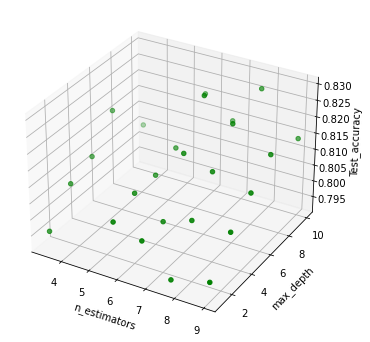

In [303]:
import math
fig = plt.figure(figsize=(6,6))
ax1 = plt.axes(projection = "3d")

df_tree1['n_estimators_log'] = df_tree1.apply(lambda r : math.log(r['n_estimators'],2) , axis = 1)

X = df_tree1['n_estimators_log']
Y = df_tree1['max_depth']
Z = df_tree1['Test_accuracy']


ax1.scatter(X, Y, Z, c='g', marker='o')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('max_depth')
ax1.set_zlabel('Test_accuracy')
plt.show()

In [8]:
addenv_factor_all = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

addenv_factor_all = addenv_factor_all.drop(['stock_code','stock_report_date'],axis=1)

X_all_scaled = pd.DataFrame()
a, b = addenv_factor_all.shape

for i in range(b):
    addenv_factor_all_new = mean_norm(addenv_factor_all[addenv_factor_all.columns[i]])
    X_all_scaled.insert(i,addenv_factor_all.columns[i],addenv_factor_all_new)
X_all_scaled

X_all_scaled.to_csv("./X_all_scaled.CSV")